# Agrupamento hierárquico

Vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
!pip install gower

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as shc

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [6]:
df.shape

(12330, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [8]:
# Descrevendo os dados não numéricos
df.describe(include = 'all')

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330,12330
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,3,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May,NaN,NaN,NaN,NaN,Returning_Visitor,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3364,NaN,NaN,NaN,NaN,10551,9462,10422
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,NaN,2.124006,2.357097,3.147364,4.069586,NaN,NaN,NaN
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,NaN,0.911325,1.717277,2.401591,4.025169,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,NaN,2.000000,2.000000,1.000000,2.000000,NaN,NaN,NaN
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,NaN,2.000000,2.000000,3.000000,2.000000,NaN,NaN,NaN
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,NaN,3.000000,2.000000,4.000000,4.000000,NaN,NaN,NaN


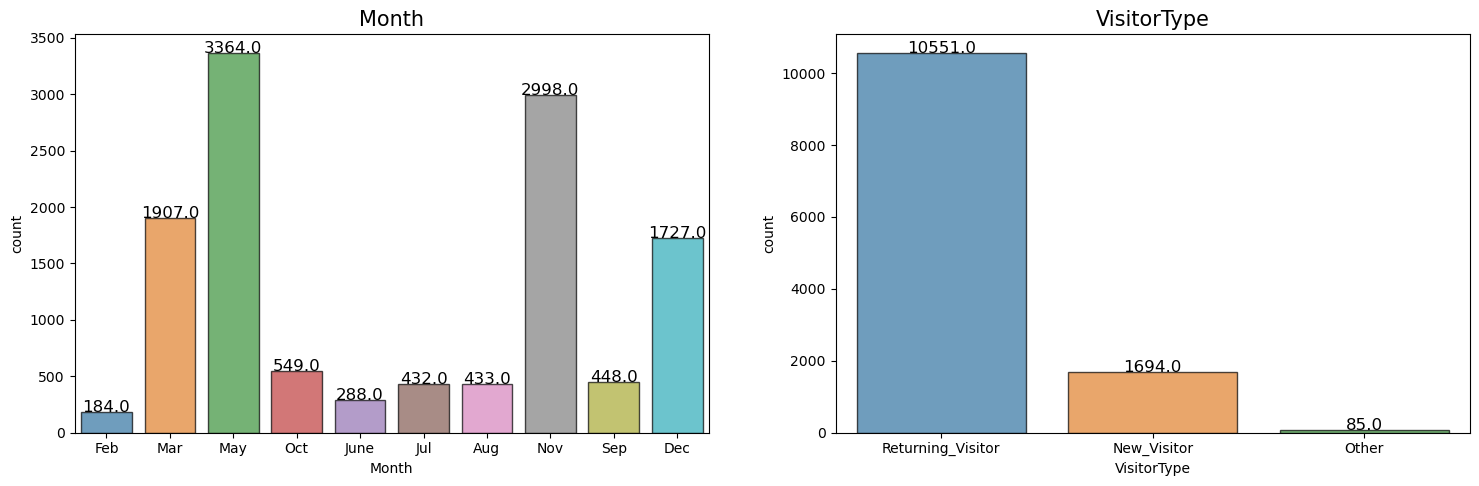

In [9]:
# Tamanho da figura
plt.figure(figsize = (18,30))

# Lista de colunas
column_list = df[['Month', 'VisitorType']]

# Contador
A = 0

# Loop
for i in column_list:
    A += 1
    plt.subplot(5, 2, A)
    ax = sns.countplot(data = df.fillna('NaN'), alpha = 0.7, edgecolor='black', x = i)
    plt.title(i, fontsize = 15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >= 7:
        plt.xticks(rotation = 45)

Text(0.5, 1.0, 'Weekend Count')

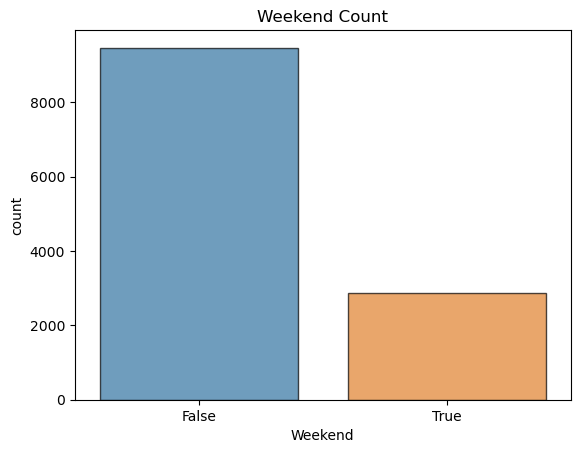

In [10]:
# Visualizando a distribuição de frequências dos valores da coluna Weekend
sns.countplot(data=df, x = 'Weekend', alpha = 0.7, edgecolor = 'black').set_title("Weekend Count")

Text(0.5, 1.0, 'Revenue Count')

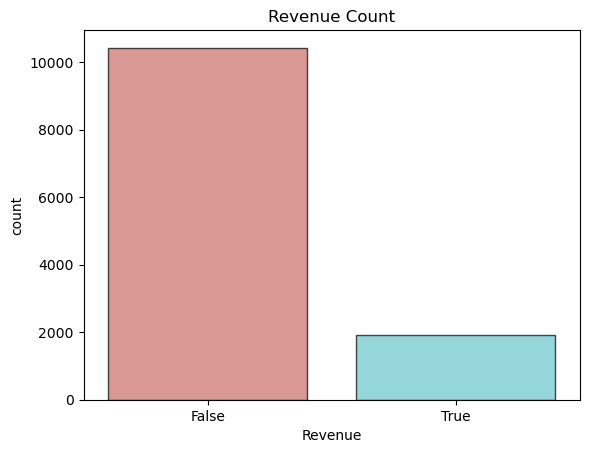

In [11]:
# Visualizando a distribuição de frequências dos valores da coluna Revenue
sns.countplot(data=df, x = 'Revenue', alpha = 0.7, edgecolor = 'black', palette='hls').set_title("Revenue Count")

Text(0.5, 1.0, 'ProductRelated_Duration Count')

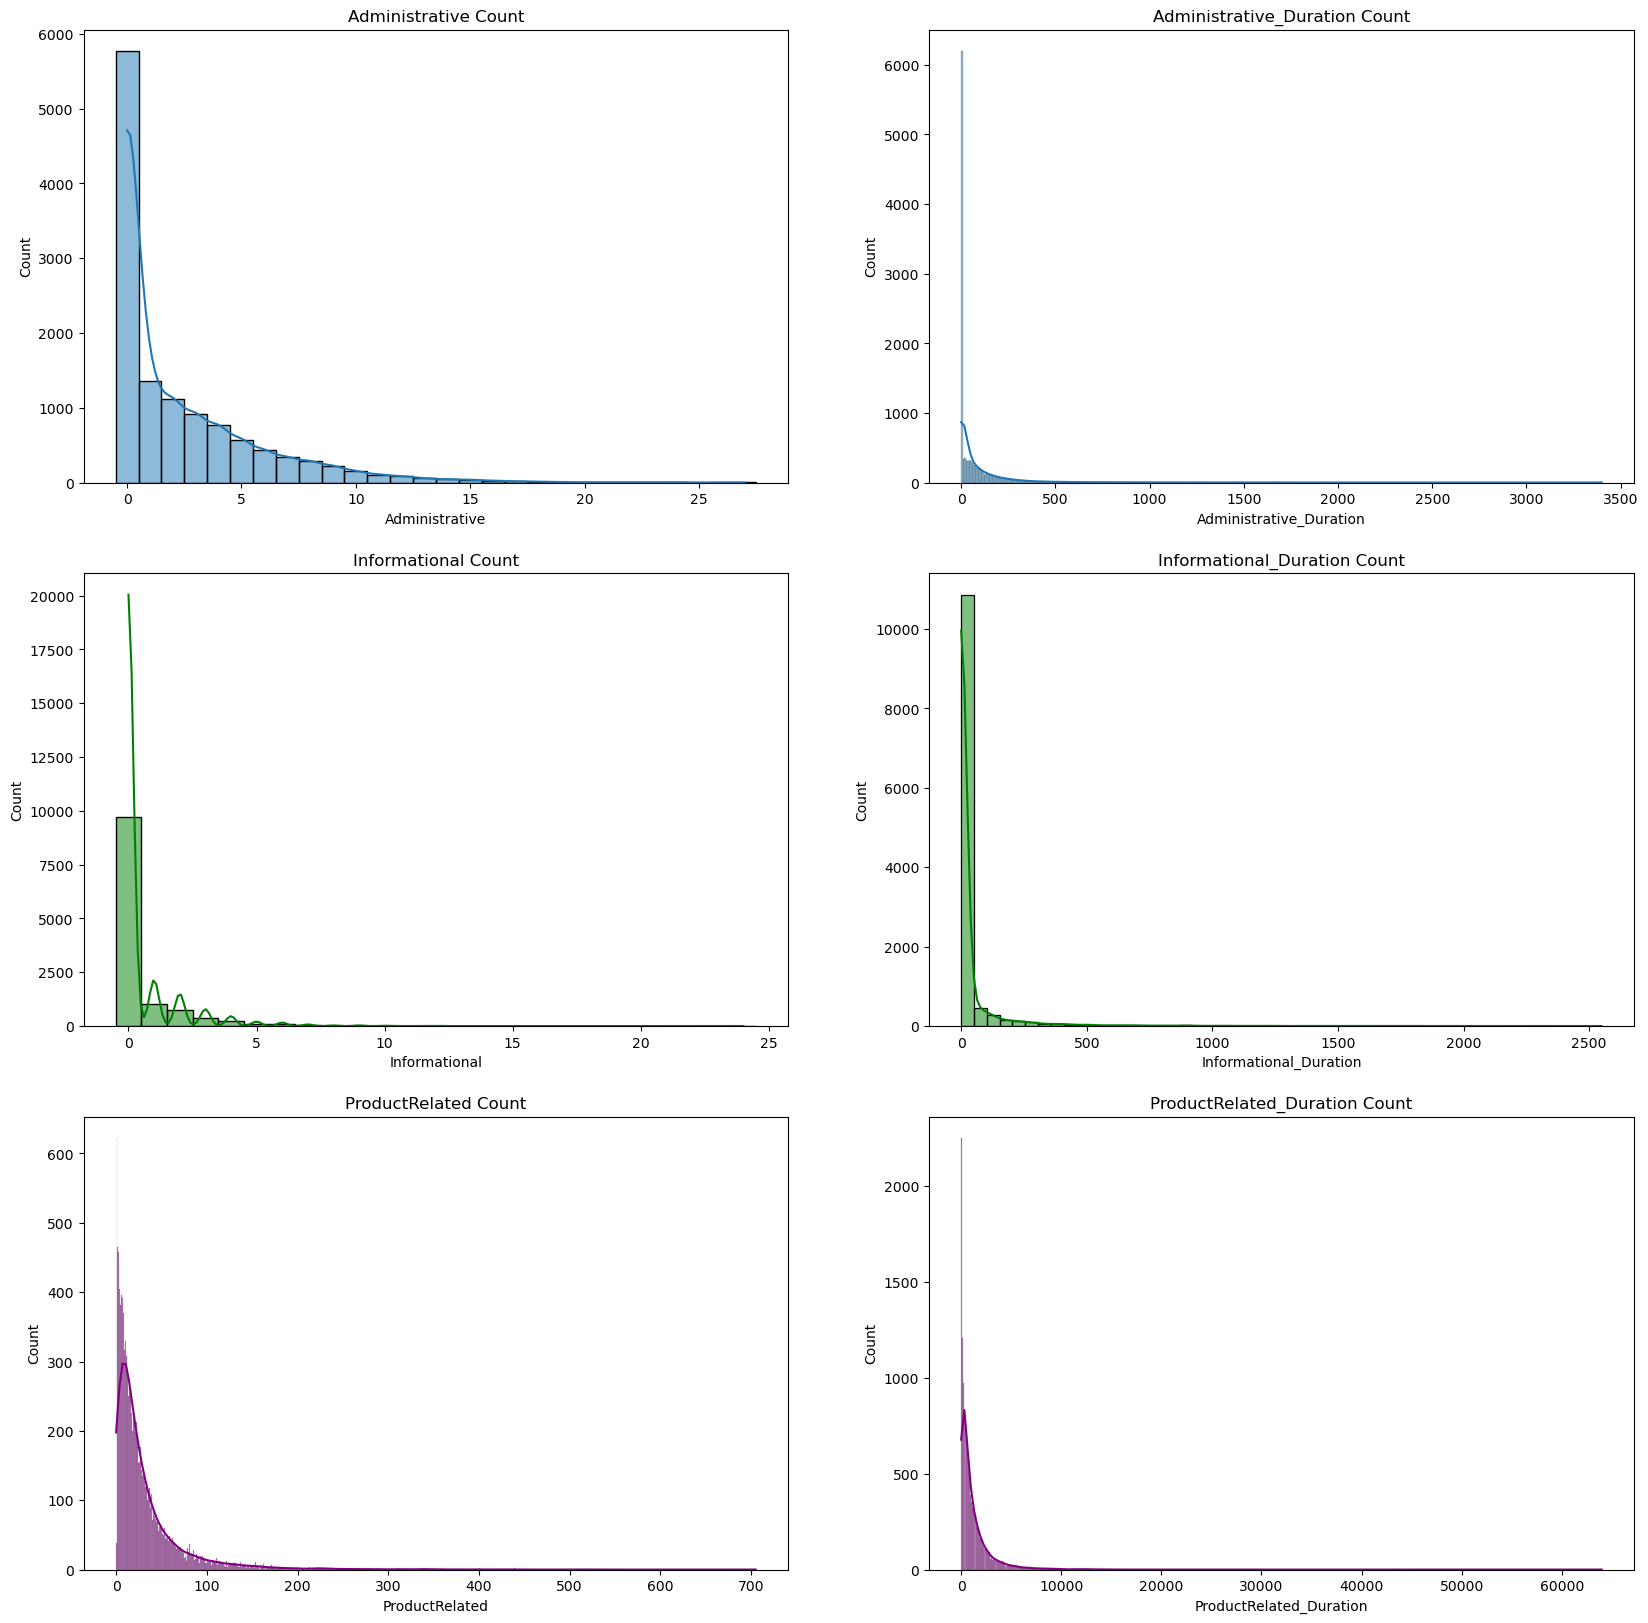

In [12]:
fig, axis = plt.subplots(3, 2, figsize=(20,20))
sns.color_palette("hls", 8)

# Subplots com histogramas
sns.histplot(data=df, x = "Administrative", discrete=True, kde = True, ax=axis[0,0])
axis[0, 0].set_title("Administrative Count")

sns.histplot(data=df, x = "Administrative_Duration", kde = True, ax=axis[0,1])
axis[0, 1].set_title("Administrative_Duration Count")

sns.histplot(data=df, x = "Informational", discrete=True, kde = True, color='green', ax=axis[1,0])
axis[1, 0].set_title("Informational Count")

sns.histplot(data=df, x = "Informational_Duration", bins=50, kde = True, color='green', ax=axis[1,1])
axis[1, 1].set_title("Informational_Duration Count")

sns.histplot(data=df, x = "ProductRelated", discrete=True, kde = True, color='purple', ax=axis[2,0])
axis[2, 0].set_title("ProductRelated Count")

sns.histplot(data=df, x = "ProductRelated_Duration", kde = True, color='purple', ax=axis[2,1])
axis[2, 1].set_title("ProductRelated_Duration Count")

Text(0.5, 1.0, 'ProductRelated_Duration Count')

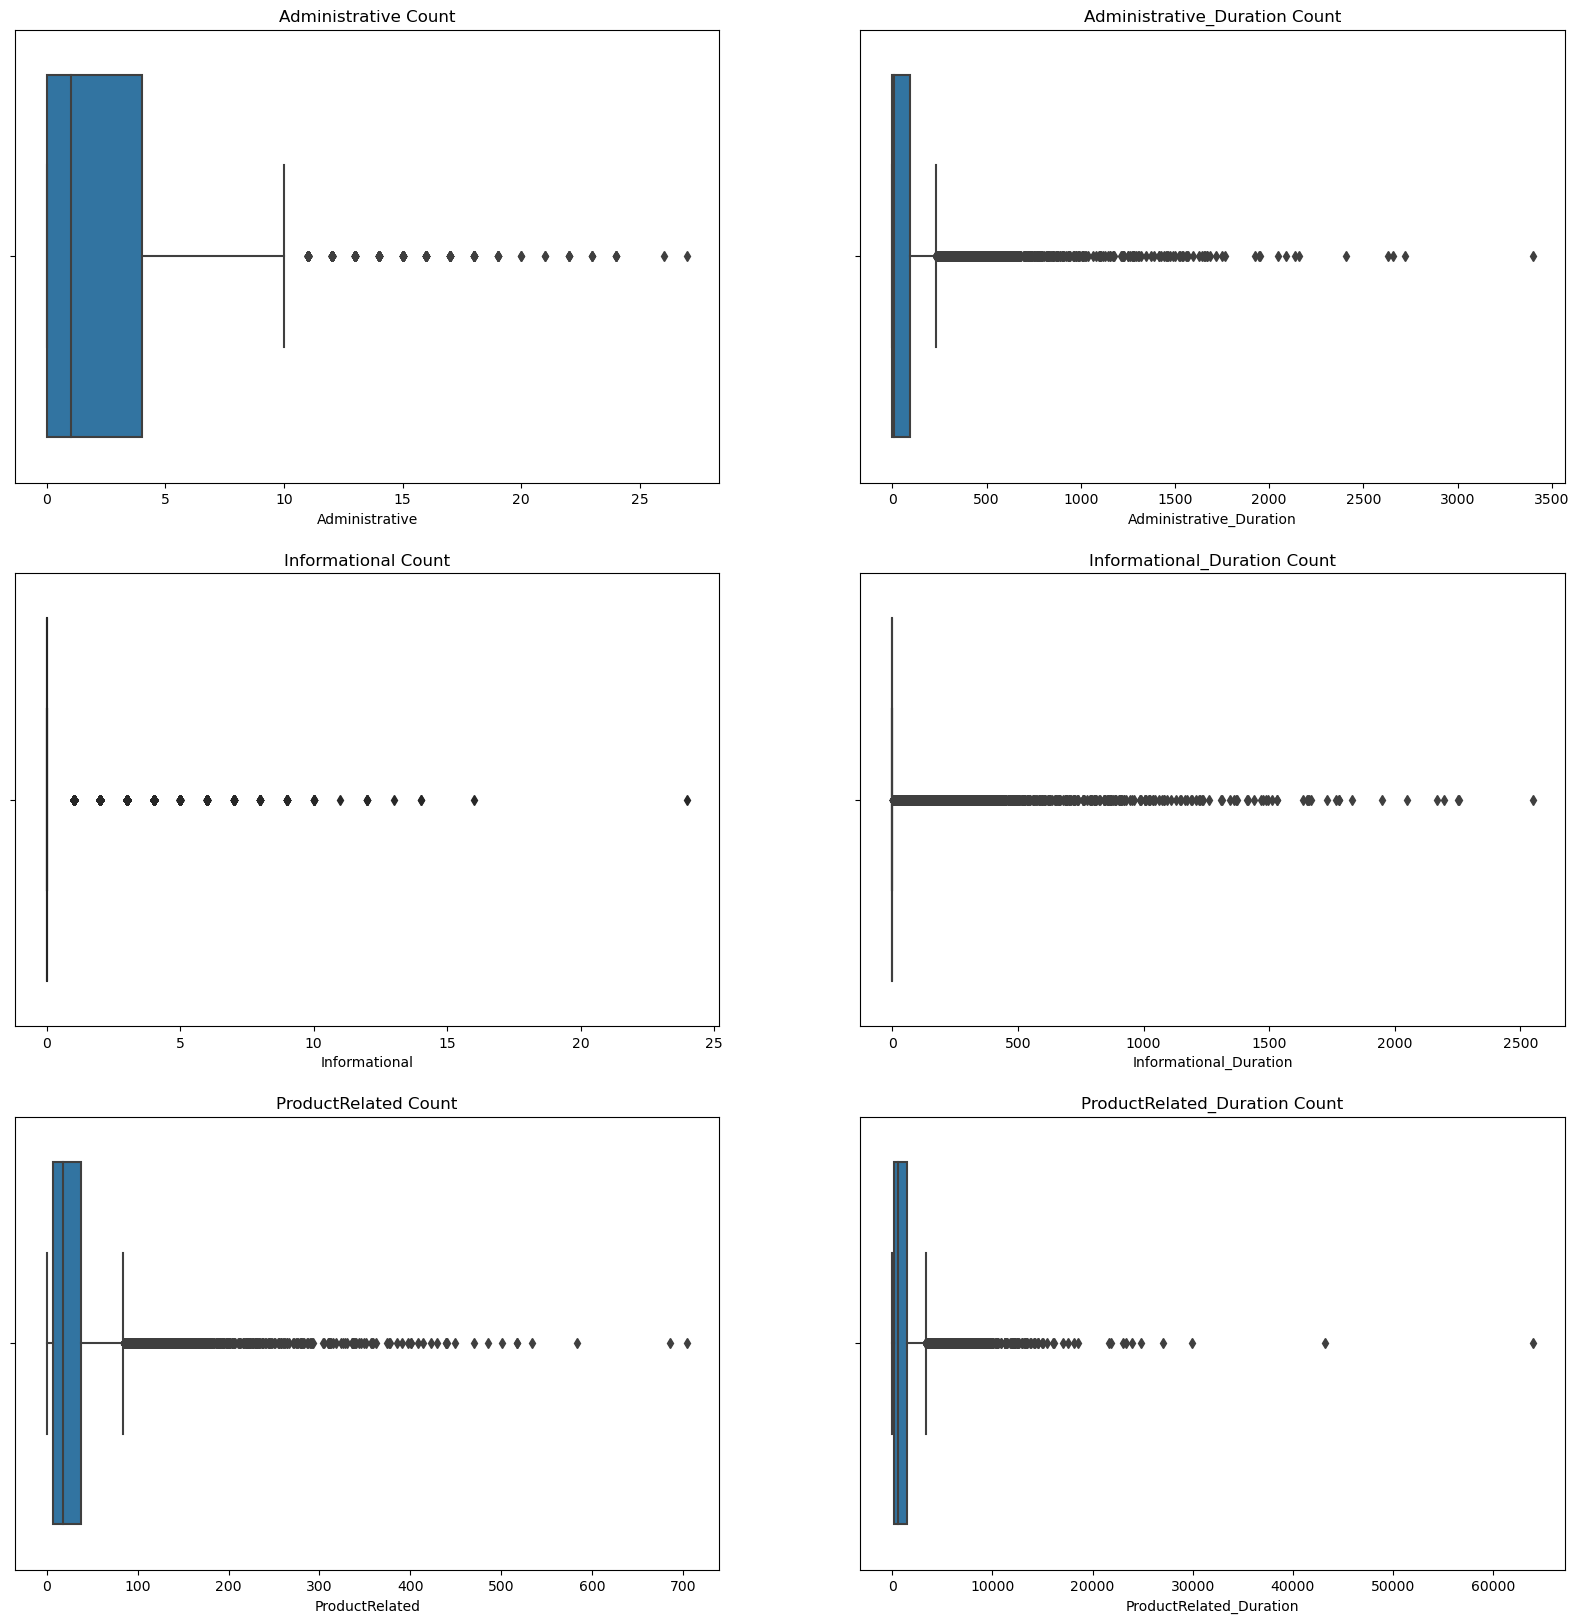

In [13]:
fig, axis = plt.subplots(3, 2, figsize=(20,20))
sns.color_palette("hls", 8)

# Subplots com histogramas
sns.boxplot(data=df, x = "Administrative", ax=axis[0,0])
axis[0, 0].set_title("Administrative Count")

sns.boxplot(data=df, x = "Administrative_Duration", ax=axis[0,1])
axis[0, 1].set_title("Administrative_Duration Count")

sns.boxplot(data=df, x = "Informational", color='green', ax=axis[1,0])
axis[1, 0].set_title("Informational Count")

sns.boxplot(data=df, x = "Informational_Duration", ax=axis[1,1])
axis[1, 1].set_title("Informational_Duration Count")

sns.boxplot(data=df, x = "ProductRelated", ax=axis[2,0])
axis[2, 0].set_title("ProductRelated Count")

sns.boxplot(data=df, x = "ProductRelated_Duration", ax=axis[2,1])
axis[2, 1].set_title("ProductRelated_Duration Count")

Text(0.5, 1.0, 'SpecialDay Count')

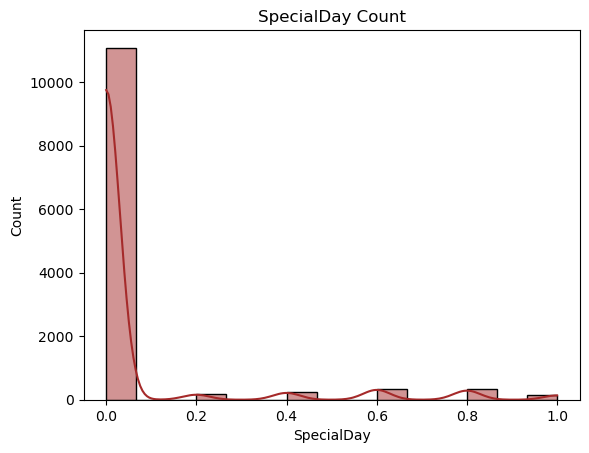

In [14]:
ax = sns.histplot(data=df, x = "SpecialDay",kde = True, color='brown')
ax.set_title("SpecialDay Count")

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [15]:
# Variáveis que vamos utilizar
variaveis = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'SpecialDay', 'Month', 'Weekend']
variaveis_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']
variaveis_cat = ['SpecialDay', 'Month', 'Weekend']

In [16]:
# padronizando variáveis quantitativas
padronizador = StandardScaler()
df_pad = padronizador.fit_transform(df[variaveis_qtd])
df_pad = pd.DataFrame(df_pad, columns = df[variaveis_qtd].columns)

# Atribuindo o conteúdo do dataframe original no dataframe padronizado
df_pad[variaveis_cat] = df[variaveis_cat]

#Transformando em dummies
df_pad = pd.get_dummies(df_pad[variaveis].dropna(), columns=variaveis_cat)

df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay_0.0,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Weekend_False,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

### Agrupamentos com 3

In [17]:
df_pad.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'SpecialDay_0.0', 'SpecialDay_0.2', 'SpecialDay_0.4', 'SpecialDay_0.6',
       'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'],
      dtype='object')

In [18]:
df_pad.shape

(12330, 24)

In [19]:
vars_cat = [True if x in {'SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'} else False for x in df_pad.columns]

In [20]:
%%time

# calculando as distâncias
distancia_gower = gower_matrix(df_pad, cat_features=vars_cat)

# ajustando a matriz de distâncias para alimentar o algoritmo com este objeto
gdv = squareform(distancia_gower, force='tovector')

CPU times: total: 34 s
Wall time: 34.5 s


In [21]:
# Fazendo o agrupamento
Z = linkage(gdv, method='complete')

# Classificar as observações
df_pad['grupos_3'] = fcluster(Z, 3, criterion='maxclust')
df_pad.grupos_3.value_counts()

2    6657
1    2840
3    2833
Name: grupos_3, dtype: int64

In [22]:
# Pegando a base original e fazendo um left join 
df2 = df.join(df_pad['grupos_3'], how='left')
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,grupos_3
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,3
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,3
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,3
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,3
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,3


### Agrupamentos com 4

In [23]:
# Fazendo o agrupamento
Z = linkage(gdv, method='complete')

# Classificar as observações
df_pad['grupos_4'] = fcluster(Z, 4, criterion='maxclust')
df_pad.grupos_4.value_counts()

2    6657
1    2840
3    2649
4     184
Name: grupos_4, dtype: int64

In [24]:
# Pegando a base original e fazendo um left join 
df2 = df2.join(df_pad['grupos_4'], how='left')
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,grupos_3,grupos_4
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,3,4
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,3,4
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,3,4
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,3,4
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,3,4


### Agrupamentos com 2

In [25]:
# Fazendo o agrupamento
Z = linkage(gdv, method='complete')

# Classificar as observações
df_pad['grupos_2'] = fcluster(Z, 2, criterion='maxclust')
df_pad.grupos_2.value_counts()

2    9490
1    2840
Name: grupos_2, dtype: int64

In [26]:
# Pegando a base original e fazendo um left join 
df2 = df2.join(df_pad['grupos_2'], how='left')
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,grupos_3,grupos_4,grupos_2
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,1,1,1,Returning_Visitor,False,False,3,4,2
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,2,1,2,Returning_Visitor,False,False,3,4,2
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,4,1,9,3,Returning_Visitor,False,False,3,4,2
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,3,2,2,4,Returning_Visitor,False,False,3,4,2
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,3,3,1,4,Returning_Visitor,True,False,3,4,2


### Agrupamentos com 5

In [27]:
# Fazendo o agrupamento
Z = linkage(gdv, method='complete')

# Classificar as observações
df_pad['grupos_5'] = fcluster(Z, 5, criterion='maxclust')
df_pad.grupos_5.value_counts()

3    6657
1    2839
4    2649
5     184
2       1
Name: grupos_5, dtype: int64

In [28]:
# Pegando a base original e fazendo um left join 
df2 = df2.join(df_pad['grupos_5'], how='left')
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,grupos_3,grupos_4,grupos_2,grupos_5
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,1,1,Returning_Visitor,False,False,3,4,2,5
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,1,2,Returning_Visitor,False,False,3,4,2,5
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,9,3,Returning_Visitor,False,False,3,4,2,5
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,2,2,4,Returning_Visitor,False,False,3,4,2,5
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,3,1,4,Returning_Visitor,True,False,3,4,2,5


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada. Trateremos variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

In [39]:
df2['BounceRates'] = df['BounceRates']
df2['Revenue'] = df['Revenue']
df2['grupos_2'].replace({1:"g_1", 2:"g_2"}, inplace=True)
df2['grupos_3'].replace({1:"g_1", 2:"g_2", 3:"g_3"}, inplace=True)
df2['grupos_4'].replace({1:"g_1", 2:"g_2", 3:"g_3", 4:"g_4"}, inplace=True)
df2['grupos_5'].replace({1:"g_1", 2:"g_2", 2:"g_3", 4:"g_4", 5:"g_5"}, inplace=True)

- Agrupamento 2

In [40]:
# Tabela cruzada entre coluna Revenue e grupos_2
pd.crosstab(df2.Revenue, df2.grupos_2)

grupos_2,grupo_1,grupo_2
Revenue,,
False,2342,8080
True,498,1410


<Axes: xlabel='BounceRates', ylabel='grupos_2'>

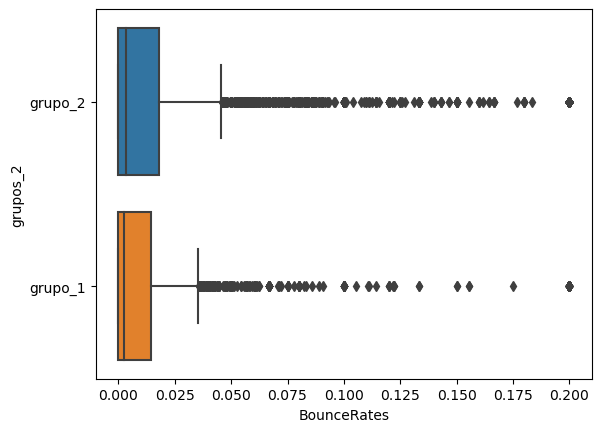

In [41]:
# Plotando a variável BounceRates em relação ao grupo 2
sns.boxplot(data=df2, y='grupos_2', x='BounceRates')

- Agrupamento com 3

In [42]:
# Tabela cruzada entre coluna Revenue e grupos_3
pd.crosstab(df2.Revenue, df2.grupos_3)

grupos_3,g_1,g_2,g_3
Revenue,,,
False,2342,5516,2564
True,498,1141,269


<Axes: xlabel='BounceRates', ylabel='grupos_3'>

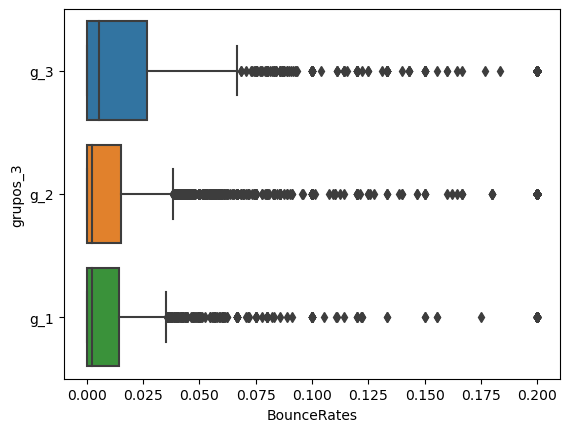

In [43]:
# Plotando a variável BounceRates em relação ao grupo 3
sns.boxplot(data=df2, y='grupos_3', x='BounceRates')

- Agrupamento com 4

In [44]:
# Tabela cruzada entre coluna Revenue e grupos_4
pd.crosstab(df2.Revenue, df2.grupos_4)

grupos_4,g_1,g_2,g_3,g_4
Revenue,,,,
False,2342,5516,2383,181
True,498,1141,266,3


<Axes: xlabel='BounceRates', ylabel='grupos_4'>

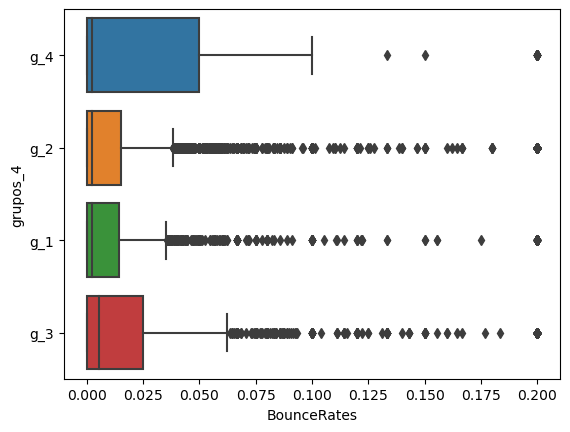

In [45]:
# Plotando a variável BounceRates em relação ao grupo 4
sns.boxplot(data=df2, y='grupos_4', x='BounceRates')

- Agrupamento com 5

In [46]:
# Tabela cruzada entre coluna Revenue e grupos_5
pd.crosstab(df2.Revenue, df2.grupos_5)

grupos_5,3,g_1,g_3,g_4,g_5
Revenue,,,,,
False,5516,2341,1,2383,181
True,1141,498,0,266,3


<Axes: xlabel='BounceRates', ylabel='grupos_5'>

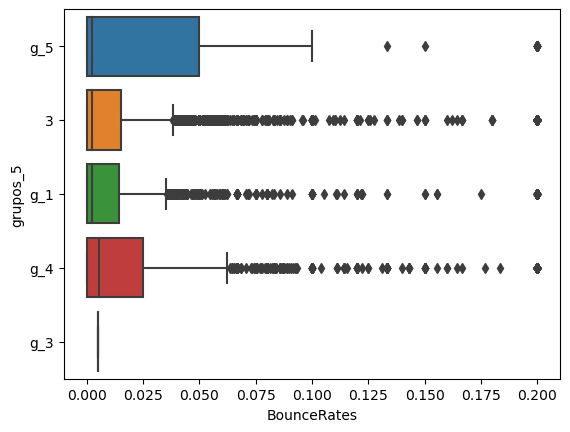

In [47]:
# Plotando a variável BounceRates em relação ao grupo 5
sns.boxplot(data=df2, y='grupos_5', x='BounceRates')

- Utilizando 3 grupos temos os melhores resultados.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [58]:
# Porcentagem de True e False
pd.crosstab(df2.Revenue, df2.grupos_3, normalize='columns')

grupos_3,g_1,g_2,g_3
Revenue,,,
False,0.824648,0.828601,0.905048
True,0.175352,0.171399,0.094952


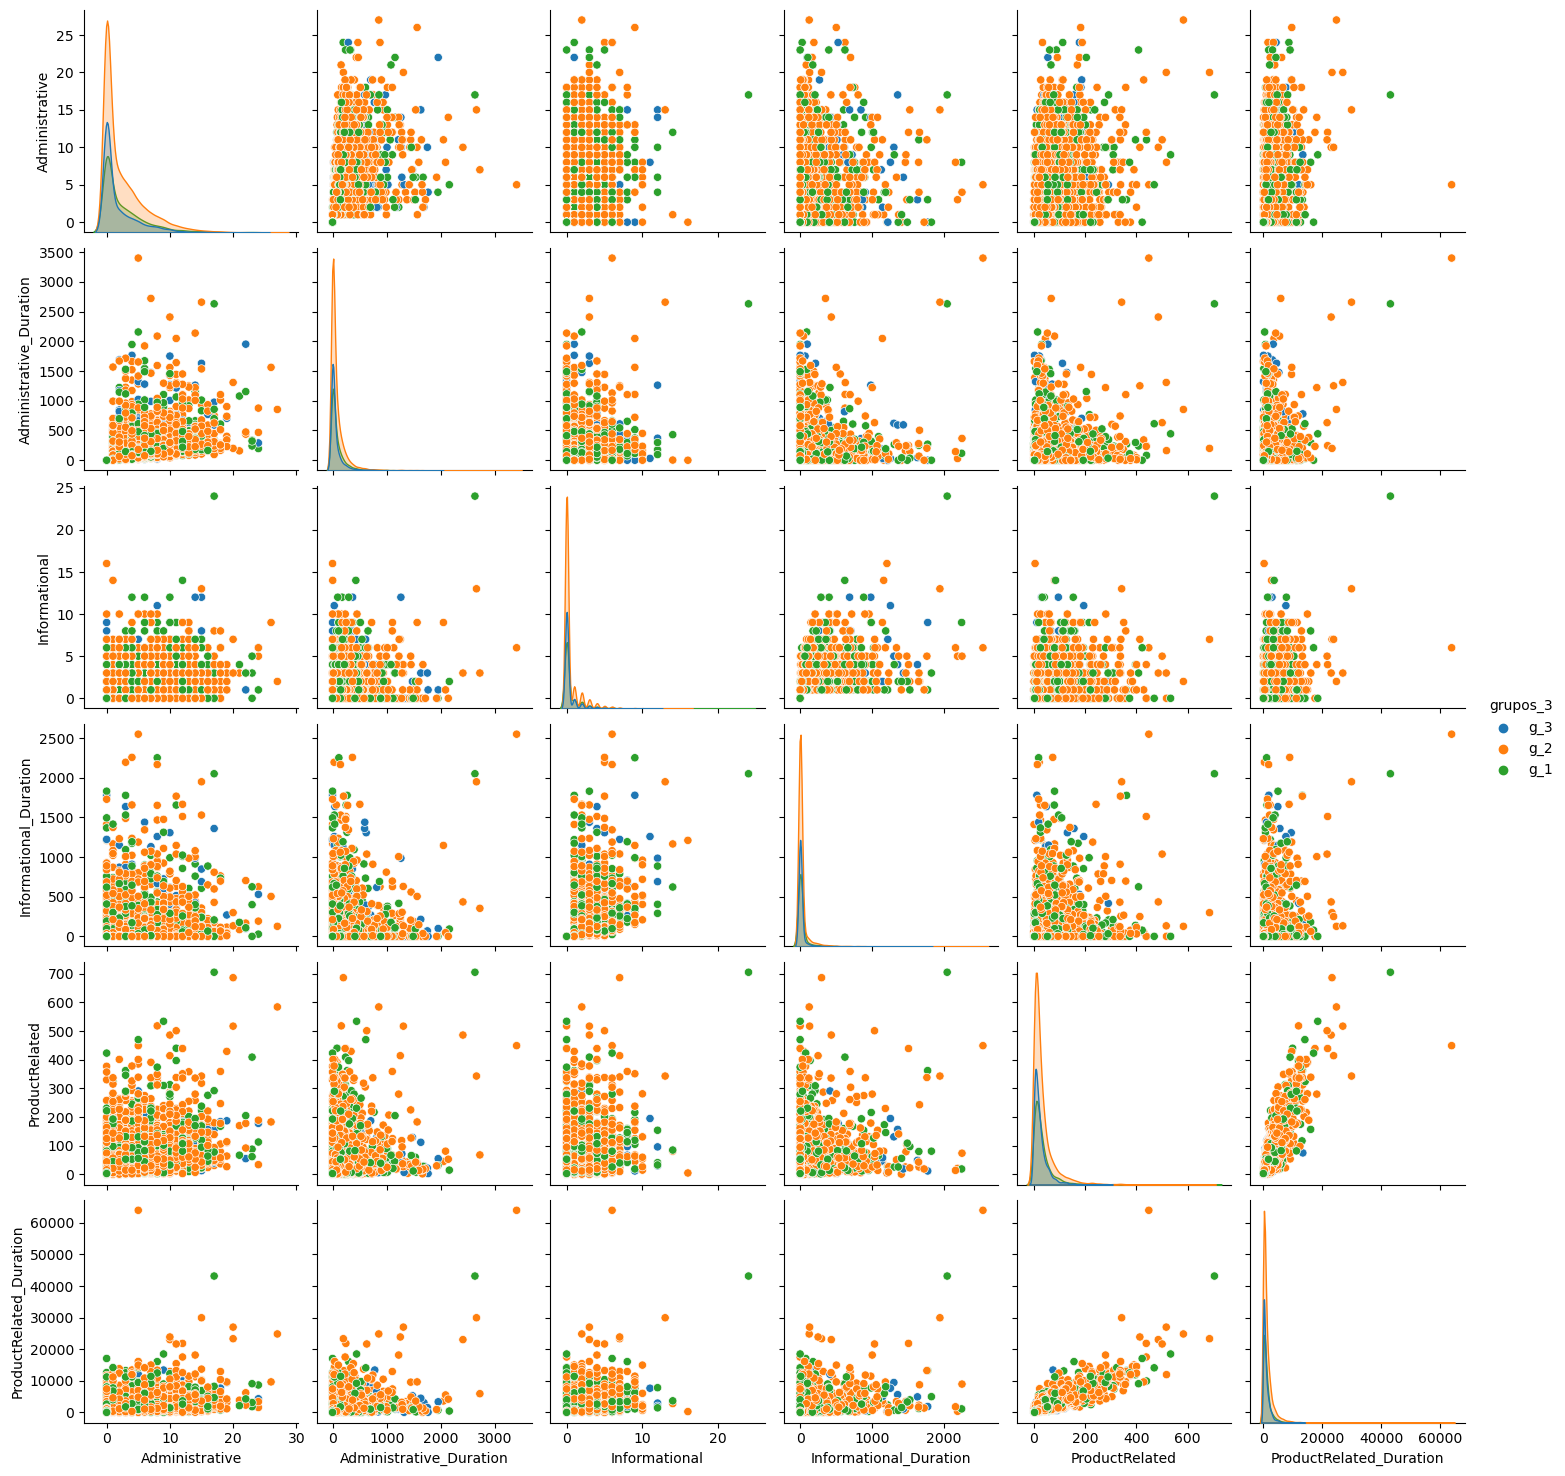

In [59]:
# Plot da relação entre as variáveis
sns.pairplot(df2[['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'grupos_3']], hue='grupos_3')

<Axes: xlabel='Weekend', ylabel='count'>

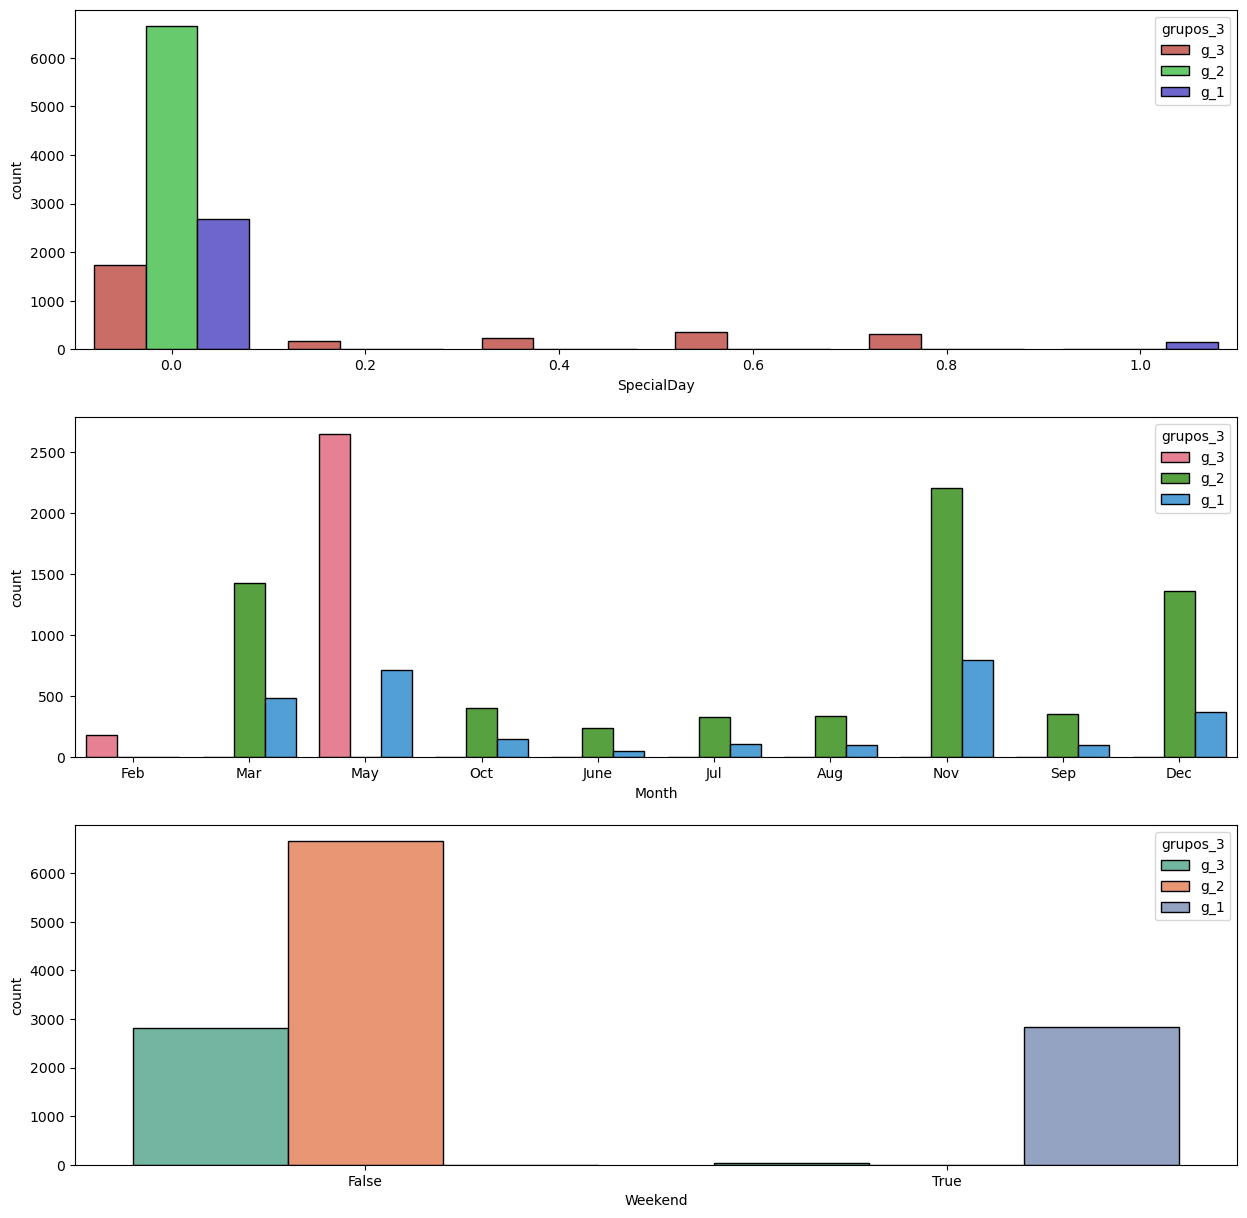

In [60]:
# Distribuição das variáveis
fig, axis = plt.subplots(3, 1, figsize=(15,15))

sns.countplot(data=df2, x = "SpecialDay", hue='grupos_3', palette ='hls', edgecolor='black', ax=axis[0])
sns.countplot(data=df2, x = "Month", hue='grupos_3', palette ='husl', edgecolor='black', ax=axis[1])
sns.countplot(data=df2, x = "Weekend", hue='grupos_3', palette ='Set2', edgecolor='black', ax=axis[2])

Podemos identificar que o grupo_2 é o que apresenta maior probabilidade de realizar compras, uma vez que possui a maior taxa de Revenue = True e menores índices de Bounce Rate. Os resultados indicam que os clientes pertencentes a esse grupo costumam acessar as páginas do site com maior frequência aos finais de semana e tem uma frequência constante ao longo do ano.